In [4]:
transform=transforms.Compose(
    [   transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize(mean = [0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ]
)

In [5]:
import torch
from torchvision import datasets, transforms
data_train = datasets.MNIST(root = "data/", transform = transform, train = True, download = True)
data_test = datasets.MNIST(root = "data/", transform = transform, train = False )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/Users/tommyzhou/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
data_loader_train = torch.utils.data.DataLoader(dataset = data_train,
                                                shuffle=True,
                                                batch_size=64)
data_loader_test = torch.

[tensor(4), tensor(0), tensor(1), tensor(6), tensor(4), tensor(3), tensor(6), tensor(7), tensor(3), tensor(6), tensor(9), tensor(7), tensor(7), tensor(4), tensor(3), tensor(0), tensor(7), tensor(4), tensor(9), tensor(4), tensor(5), tensor(6), tensor(8), tensor(6), tensor(1), tensor(3), tensor(4), tensor(4), tensor(4), tensor(3), tensor(0), tensor(7), tensor(6), tensor(2), tensor(4), tensor(7), tensor(8), tensor(8), tensor(0), tensor(0), tensor(0), tensor(9), tensor(1), tensor(9), tensor(4), tensor(9), tensor(4), tensor(5), tensor(6), tensor(7), tensor(8), tensor(6), tensor(4), tensor(1), tensor(3), tensor(0), tensor(5), tensor(3), tensor(7), tensor(1), tensor(7), tensor(4), tensor(3), tensor(8)]


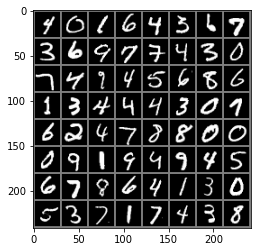

In [9]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std + mean
print([labels[i] for i in range(64)])
plt.imshow(img)

# 全联接手写识别

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [11]:
BATCH_SIZE = 16 # 每批处理的数据个数
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 是使用GPU还是CPU进行训练
EPOCHS = 10 # 训练数据集的轮数

In [12]:
pipeline = transforms.Compose([
 transforms.ToTensor(), #将图片转换成tensor
 transforms.Normalize((0.1307,),(0.3081,)) # 正则化，用来降低模型复杂度
])

In [13]:
from torch.utils.data import DataLoader
# 下载数据集
data_train = datasets.MNIST(root="data/", transform=pipeline, train=True, download=True)
data_test = datasets.MNIST(root="data/", transform=pipeline, train=False, download=True)
# 加载数据
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
            
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [15]:
## 补充定义超参数
INPUT_SIZE = 784
HIDDEN_SIZE1 = 256
HIDDEN_SIZE2 = 512
OUTPUT_SIZE = 10
LEARNING_RATE = 0.01
model = FCNet(INPUT_SIZE, HIDDEN_SIZE1, HIDDEN_SIZE2, OUTPUT_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
total_step = len(train_loader)
def train_model(model,device,train_loader,optimizer,epoch):
     # 模型训练
    model.train()
    for batch_index,(data, label) in enumerate(train_loader):
         # 部署到DEVICE上
        data, label = data.reshape(-1, 28 * 28).to(DEVICE), label.to(DEVICE)
 # 将模型参数的梯度初始化为0
        optimizer.zero_grad()
 # 前向传播计算预测值
        output = model(data)
 # 计算当前损失
        loss = F.cross_entropy(output, label)
 # 反向传播计算梯度
        loss.backward()
 # 更新所有参数
        optimizer.step()
        if batch_index % 3000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, EPOCHS, batch_index+1, total_step,loss)) 

In [ ]:
# 8 定义测试方法
def test_model(model, device, test_loader):
 # 模型验证
    model.eval()
 # 正确率
    correct = 0.0
 # 测试损失
    test_loss = 0.0
    with torch.no_grad(): # 在测试阶段，不用计算梯度，也不用进行反向传播
        for data, label in test_loader:
 # 部署到DEVICE上
            data, label = data.reshape(-1, 28 * 28).to(device), label.to(device)
 # 测试数据
            output = model(data)
 # 计算测试损失
 test_loss += F.cross_entropy(output, label).item()
 # 找到概率最大值的下标
 _, predict = torch.max(output, dim=1) # 这里返回最大值和最大值索引
 # 累计正确的值
 correct += predict.eq(label.view_as(predict)).sum().item()
 test_loss /= len(test_loader.dataset)
 print("Test -- Average loss : {:.4f}, Accuracy : {:.3f}\n".format(test_loss, 100.0 * correc